In [19]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse.linalg import spsolve
import pandas as pd
from sklearn.linear_model import LinearRegression
np.random.seed(seed=42)

In [21]:
N = 20000
paths = 5000
T = 5
T_vec, dt = np.linspace(0, T, N, retstep=True)

In [23]:
df = pd.read_csv("vasicek_short_rates.csv", sep=";")
rates = df["Rate"].values
dt = 1/252

In [25]:
def calibrate_vasicek(rates, dt):
    r_t = rates[:-1].reshape(-1, 1)
    r_next = rates[1:]
    dr = r_next - r_t.flatten()
    reg = LinearRegression().fit(r_t, dr)
    a = reg.intercept_
    b = reg.coef_[0]

    # Paramètres Vasicek
    kappa = -b / dt
    theta = a / (kappa * dt)

    # Volatilité
    residuals = dr - (a + b*r_t.flatten())
    sigma = np.std(residuals) / np.sqrt(dt)

    return kappa, theta, sigma

In [27]:
kappa, theta, sigma = calibrate_vasicek(rates, dt)

print("Paramètres Vasicek calibrés :")
print(f"kappa = {kappa:.4f}")
print(f"theta = {theta:.4f}")
print(f"sigma = {sigma:.4f}")

Paramètres Vasicek calibrés :
kappa = 66.0038
theta = 0.0165
sigma = 0.0036


In [29]:
kappa = 66.0038
theta = 0.0165
sigma = 0.0145
std_asy = np.sqrt(sigma**2 / (2 * kappa))

In [31]:
#Simulation Ornstein Uhlenbeck
X0 = 2  #taux d'intérêt de départ (peut être changé)
X = np.zeros((N, paths))
X[0, :] = X0
W = ss.norm.rvs(loc=0, scale=1, size=(N - 1, paths))

std_dt = np.sqrt(sigma**2 / (2 * kappa) * (1 - np.exp(-2 * kappa * dt)))
for t in range(0, N - 1):
    X[t + 1, :] = theta + np.exp(-kappa * dt) * (X[t, :] - theta) + std_dt * W[t, :]

In [33]:
#Pricing de l'obligation avec le modèle Vasicek
B = 1 / kappa * (1 - np.exp(-kappa * T))
A = np.exp((theta - sigma**2 / (2 * kappa**2)) * (B - T) - sigma**2 / (4 * kappa) * B**2)
P = A * np.exp(-B * X0)
print("Le prix de l'obligation", P)

Le prix de l'obligation 0.8935516139915856


In [35]:
#Pricing de l'obligation avec une simulation Monte Carlo
disc_factor = np.exp(-X.mean(axis=0) * T)
P_MC = np.mean(disc_factor)
st_err = ss.sem(disc_factor)
print(f"Le prix de l'obligation d'après MC {P_MC} avec une précision: {st_err}")

Le prix de l'obligation d'après MC 0.9188343334576115 avec une précision: 1.5970415670171294e-06


In [37]:
#Pricing de l'obligation par résolution de l'equation différentielle
Nspace = 6000  
Ntime = 6000  
r_max = 3  
r_min = -0.8  
r, dr = np.linspace(r_min, r_max, Nspace, retstep=True)  
T_array, Dt = np.linspace(0, T, Ntime, retstep=True)  
Payoff = 1  

In [39]:
V = np.zeros((Nspace, Ntime))  
offset = np.zeros(Nspace - 2)  
V[:, -1] = Payoff  
V[-1, :] = np.exp(-r[-1] * (T - T_array))  
V[0, :] = np.exp(-r[0] * (T - T_array))  

In [41]:
#Calcul de la matrice (3X3)
sig2 = sigma * sigma
drr = dr * dr
max_part = np.maximum(kappa * (theta - r[1:-1]), 0)  
min_part = np.minimum(kappa * (theta - r[1:-1]), 0)  

In [43]:
a = min_part * (Dt / dr) - 0.5 * (Dt / drr) * sig2
b = 1 + Dt * r[1:-1] + (Dt / drr) * sig2 + Dt / dr * (max_part - min_part)
c = -max_part * (Dt / dr) - 0.5 * (Dt / drr) * sig2

a0 = a[0]
cM = c[-1]  
aa = a[1:]
cc = c[:-1]  
D = sparse.diags([aa, b, cc], [-1, 0, 1], shape=(Nspace - 2, Nspace - 2)).tocsc()  

for n in range(Ntime - 2, -1, -1):
    offset[0] = a0 * V[0, n]
    offset[-1] = cM * V[-1, n]
    V[1:-1, n] = spsolve(D, (V[1:-1, n + 1] - offset))

L'obligation par résolution de l'équation différentielle partielle:  0.8935522716460422


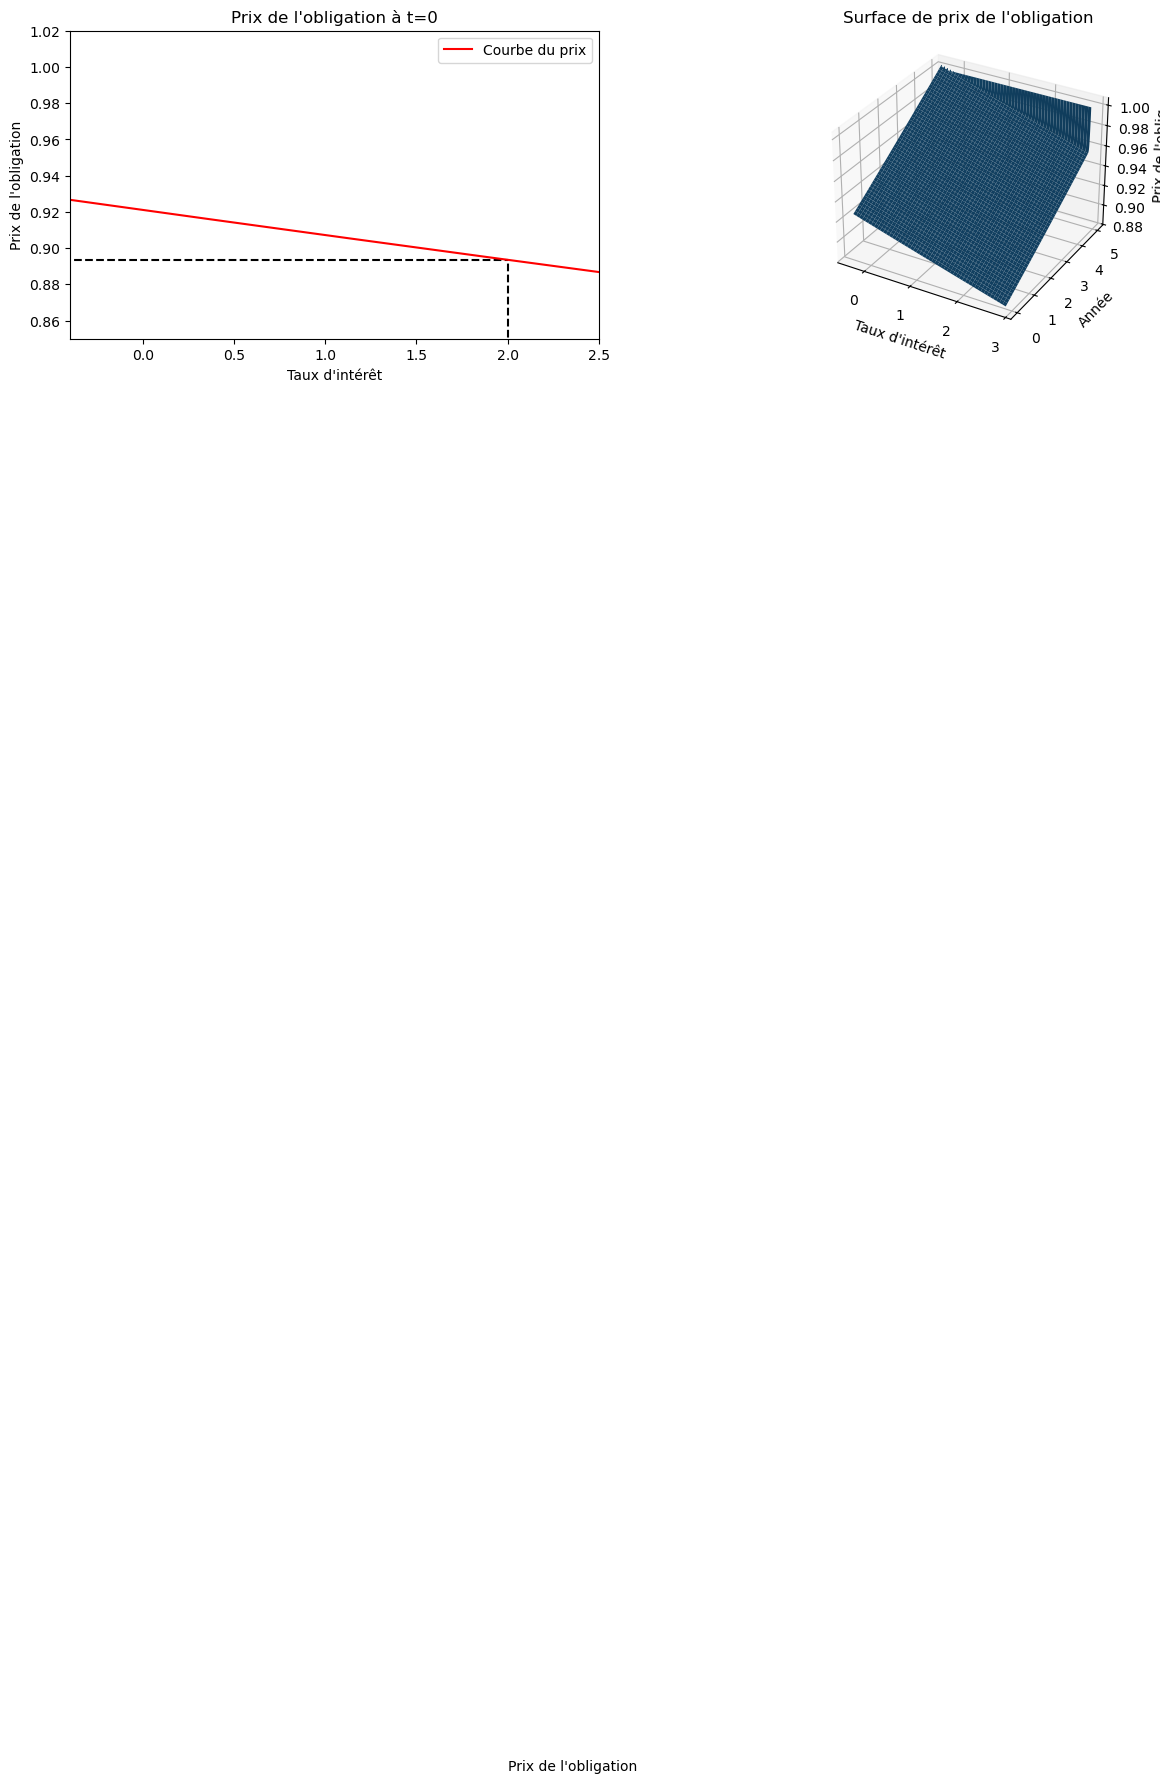

In [45]:
#visualisation
Price = np.interp(X0, r, V[:, 0])
print("L'obligation par résolution de l'équation différentielle partielle: ", Price)
fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection="3d")

ax1.text(X0, 0.06, "Prix de l'obligation")
ax1.plot([X0, X0], [0, Price], "k--")
ax1.plot([-0.5, X0], [Price, Price], "k--")
ax1.plot(r, V[:, 0], color="red", label="Courbe du prix")
ax1.set_xlim(-0.4, 2.5)
ax1.set_ylim(0.85, 1.02)
ax1.set_xlabel("Taux d'intérêt")
ax1.set_ylabel("Prix de l'obligation")
ax1.legend(loc="upper right")
ax1.set_title("Prix de l'obligation à t=0")

X_plt, Y_plt = np.meshgrid(T_array, r[700:-200])  # consider [700:-200] to remove lateral boundary effects
ax2.plot_surface(Y_plt, X_plt, V[700:-200])
ax2.set_title("Surface de prix de l'obligation")
ax2.set_xlabel("Taux d'intérêt")
ax2.set_ylabel("Année")
ax2.set_zlabel("Prix de l'oblig")
plt.show()